In [24]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [44]:
df = pd.read_csv('extracted_features/df_features_cutted_classes_mfcc7.csv')
print(df.shape)
df.head()

(3418, 73)


,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,22564_Wedding_music.wav,0.115,0.151,1.317,0.716,0.070,0.052,0.145,0.042,129.199,...,0.203,0.293,0.194,0.246,0.248,0.276,0.375,0.272,0.350,8
1,2170_Wedding_music.wav,0.100,0.130,1.386,0.846,0.063,0.013,0.125,0.038,99.384,...,0.219,0.378,0.177,0.295,0.146,0.229,0.356,0.206,0.285,8
2,12235_Dance_music.wav,0.377,0.449,0.377,-0.865,0.055,0.039,0.440,0.088,129.199,...,0.219,0.291,0.283,0.260,0.271,0.307,0.322,0.291,0.294,7
3,4743_Dance_music.wav,0.092,0.120,1.304,0.652,0.128,0.051,0.115,0.032,151.999,...,0.361,0.272,0.322,0.197,0.358,0.253,0.236,0.343,0.196,7
4,17151_Wedding_music.wav,0.192,0.244,1.151,0.294,0.083,0.016,0.236,0.059,92.285,...,0.192,0.385,0.109,0.133,0.103,0.186,0.233,0.138,0.371,8


In [45]:
label_dict = {  #'Background_music':0,
                # 'Theme_music':0,
                'Jingle':0,
                #'Soundtrack_music':1,
                'Lullaby':1,
                'Video_game_music':2,
                'Christmas_music':3,
                'Dance_music':4,
                'Wedding_music':5}
                # 'Birthday_music':9} 

# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_', 1)[1]])
df.head()

,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,22564_Wedding_music.wav,0.131090,0.165733,0.220683,0.010108,0.120567,0.197581,0.159955,0.136213,0.493104,...,0.420935,0.613687,0.406852,0.510791,0.509636,0.589450,0.803965,0.535469,0.700624,5
1,2170_Wedding_music.wav,0.113689,0.142217,0.224856,0.010615,0.108156,0.040323,0.137584,0.122924,0.275864,...,0.456570,0.801325,0.370450,0.628297,0.291221,0.481651,0.762115,0.384439,0.565489,5
2,12235_Dance_music.wav,0.435035,0.499440,0.163834,0.003940,0.093972,0.145161,0.489933,0.289037,0.493104,...,0.456570,0.609272,0.597430,0.544365,0.558887,0.660550,0.687225,0.578947,0.584200,4
3,4743_Dance_music.wav,0.104408,0.131019,0.219897,0.009858,0.223404,0.193548,0.126398,0.102990,0.659230,...,0.772829,0.567329,0.680942,0.393285,0.745182,0.536697,0.497797,0.697941,0.380457,4
4,17151_Wedding_music.wav,0.220418,0.269877,0.210644,0.008462,0.143617,0.052419,0.261745,0.192691,0.224139,...,0.396437,0.816777,0.224839,0.239808,0.199143,0.383028,0.491189,0.228833,0.744283,5


In [46]:
# Train-test split of files # Same split as used for VGG model
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:-1]], 
                                                    df['label'],
                                                    random_state = 10, 
                                                    test_size = 0.2
                                                    )

# Among the test files, keep half for validation
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                random_state = 10, 
                                                test_size = 0.5
                                                )


In [47]:
experiment_path = 'mfcc_7/'
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig('plots/' + experiment_path + title.replace(" ", "_") +'.png', bbox_inches='tight')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True, cm_title='Confustion matrix'):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        roles = ['Jingle', 'Lullaby', 'Video_game', 'Christmas',
        'Dance', 'Wedding']#, 'Birthday'] # for beatiful plotting
        plot_confusion_matrix(confusion_matrix(y_test[:len(pred)], pred), classes=roles, title=cm_title)

### Logistic Regression
LR is usually done for binary classification tasks. For this multi-class classification task, the LR is implemented as a one-vs-rest method. That is, 7 separate classifiers are trained. During test time, the class with the highest prob. from among the 7 classifiers is the predicted class.

Accuracy =  0.53
F-score =  0.52
ROC AUC = 0.827
Confusion matrix, without normalization
[[26  2  6 10 13  2]
 [ 1 36  4  3  0  6]
 [ 5  4 33  4 11  8]
 [15 15  7 11  2  5]
 [ 6  0  2  4 35  3]
 [ 5  7  4  4  2 41]]
CPU times: user 542 ms, sys: 296 ms, total: 838 ms
Wall time: 427 ms


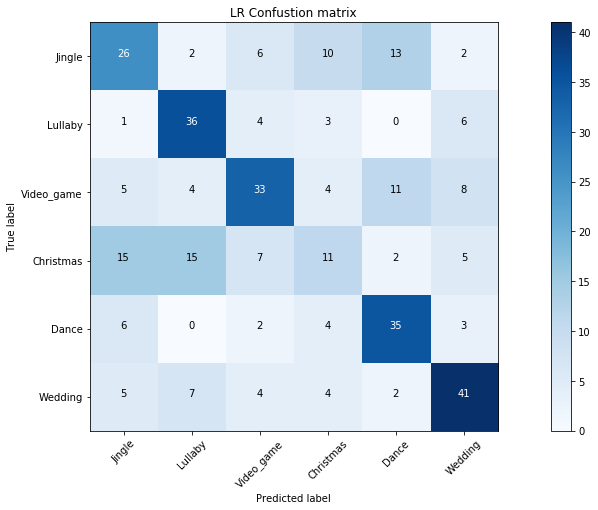

In [48]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Prediction for validation set 
pred_probs = lr_classifier.predict_proba(x_val)
display_results(y_val, pred_probs, cm_title='LR Confustion matrix')
# Save
with open('pred_probas/lr_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
# Prediction for test set
pred_probs_LR = lr_classifier.predict_proba(x_test)
# Save
with open('pred_probas/lr_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_LR, f)

### Random Forest

Accuracy =  0.57
F-score =  0.56
ROC AUC = 0.849
Confusion matrix, without normalization
[[32  1  4  9 11  2]
 [ 1 35  2  5  1  6]
 [ 6  4 32  7 10  6]
 [16 12  2 15  3  7]
 [ 6  0  0  3 37  4]
 [ 6  5  2  4  2 44]]
CPU times: user 6.25 s, sys: 392 ms, total: 6.64 s
Wall time: 6.12 s


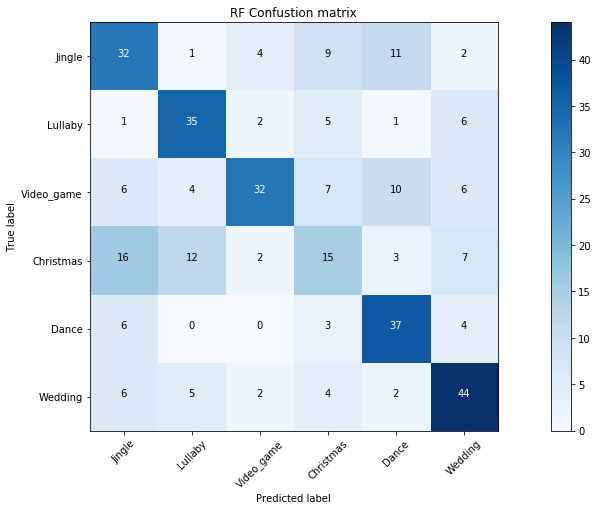

In [49]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict (validation set)
pred_probs = rf_classifier.predict_proba(x_val)
display_results(y_val, pred_probs, cm_title='RF Confustion matrix')

# Save
with open('pred_probas/rf_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
# Prediction for test set
pred_probs_RF = rf_classifier.predict_proba(x_test)
# Save
with open('pred_probas/rf_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_RF, f)

### Gradient Boosting 

Accuracy =  0.59
F-score =  0.59
ROC AUC = 0.848
Confusion matrix, without normalization
[[26  0  5 15 11  2]
 [ 0 36  2  4  1  7]
 [ 3  0 42  4 11  5]
 [15  9  2 20  2  7]
 [ 4  0  0  5 39  2]
 [ 7  6  2  7  2 39]]
CPU times: user 32.4 s, sys: 471 ms, total: 32.9 s
Wall time: 32.4 s


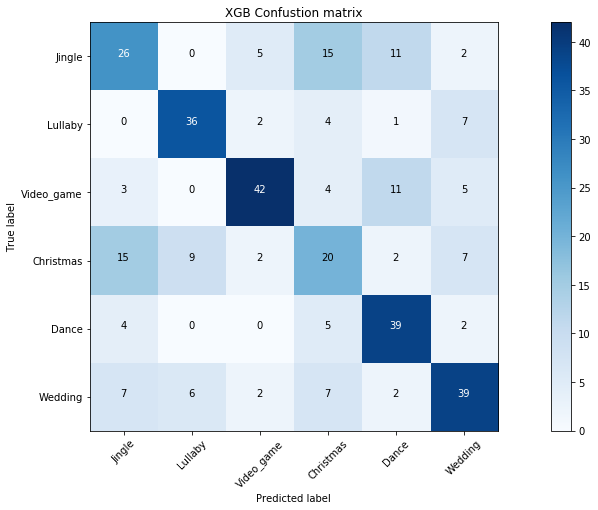

In [50]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Prediction and result (validation set)
pred_probs = xgb_classifier.predict_proba(x_val)
display_results(y_val, pred_probs, cm_title='XGB Confustion matrix')

# Save
with open('pred_probas/xgb_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
        
# Prediction for test set
pred_probs_XGB = xgb_classifier.predict_proba(x_test)
# Save
with open('pred_probas/xgb_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_XGB, f)

### Support Vector Machines

Accuracy =  0.50
F-score =  0.50
ROC AUC = 0.822
Confusion matrix, without normalization
[[25  2  5 13 11  3]
 [ 3 28  3  8  0  8]
 [ 5  3 35  7 10  5]
 [16  8  5 17  2  7]
 [ 7  0  5  5 30  3]
 [ 4  6  3  9  6 35]]
CPU times: user 18.4 s, sys: 456 ms, total: 18.8 s
Wall time: 18.2 s


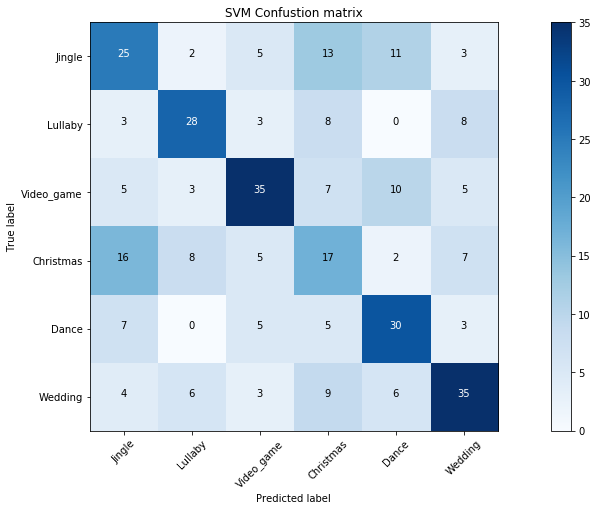

In [51]:
%%time
# Train
svm_classifier = SVC(C=10000.0, probability = True, kernel='rbf') # class_weight=cl_weight,
svm_classifier.fit(x_train, y_train)

# Predict (validation set)
pred_probs = svm_classifier.predict_proba(x_val)

# Results
display_results(y_val, pred_probs, cm_title='SVM Confustion matrix')

# Save
with open('pred_probas/svm_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
        
# Prediction for test set
pred_probs_SVM = svm_classifier.predict_proba(x_test)
# Save
with open('pred_probas/svm_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_SVM, f)

### Most Important Feature
Determine the features that contribute the most towards making the correct classfication

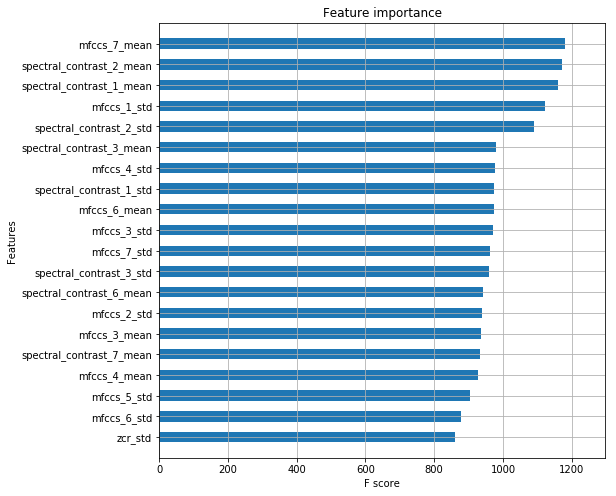

In [54]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
plt.savefig('plots/mfcc_7/feature-imp.png', bbox_inches='tight')

The most important features seem to be MFCCs and spectral contrast (mean and std dev in different frequency bins). Use the top N features, build the model and look at the metrics

In [34]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.00693882, 0.00659188, 0.01339578, 0.01540033, 0.01343433,
       0.01657608, 0.00481863, 0.01644116, 0.0126248 , 0.00961798,
       0.01574727, 0.00809529, 0.00894337, 0.00772908, 0.01100574,
       0.        , 0.        , 0.02233915, 0.02258972, 0.01890829,
       0.01578582, 0.01563163, 0.01817586, 0.01800239, 0.01879264,
       0.02098994, 0.01846498, 0.01407039, 0.01366563, 0.0156509 ,
       0.0135307 , 0.01046606, 0.01008057, 0.01597857, 0.01208512,
       0.01804094, 0.01786747, 0.01424386, 0.0187541 , 0.02274392,
       0.02160672, 0.01811804, 0.01871555, 0.01885047, 0.01742416,
       0.01690374, 0.01856135, 0.01326086, 0.0136849 , 0.011796  ,
       0.01324159, 0.01150688, 0.01015767, 0.01385837, 0.01599784,
       0.01295247, 0.0136849 , 0.01387765, 0.01540033, 0.01268263,
       0.01214294, 0.01260553, 0.01476427, 0.01499557, 0.01320304,
       0.01329941, 0.01204657, 0.01114067, 0.01370418, 0.01345361,
       0.01214294], dtype=float32)

In [35]:
top_n = [10, 20, 30, 50, 60]
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_val = selection.transform(x_val)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                       n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_val)

    # Results
    display_results(y_val, pred_probs, cm = False)     
    print()

Stats for top 10 features:
Accuracy =  0.45
F-score =  0.45
ROC AUC = 0.788
()
Stats for top 20 features:
Accuracy =  0.52
F-score =  0.52
ROC AUC = 0.818
()
Stats for top 30 features:
Accuracy =  0.55
F-score =  0.55
ROC AUC = 0.836
()
Stats for top 50 features:
Accuracy =  0.59
F-score =  0.59
ROC AUC = 0.847
()
Stats for top 60 features:
Accuracy =  0.57
F-score =  0.57
ROC AUC = 0.846
()
